In [1]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [2]:
import os, cv2, dlib 
import numpy as np
# untuk menampilkan gambar
import matplotlib.pyplot as plt

In [3]:
img_path = ['/content/drive/MyDrive/Skripsi']

class_names = ['anger', 'disgust', 'fear', 'happiness', 'neutral', 'sadness', 'surprise']
class_names_label = {class_name:i for i, class_name in enumerate(class_names)}

nb_classes = len(class_names)

for dataset in img_path:

        images = []
        labels = []

        print("Loading {}".format(dataset))
       
        for folder in os.listdir(dataset):
            label = class_names_label[folder]

            for file in os.listdir(os.path.join(dataset, folder)):
              
                img_path = os.path.join(os.path.join(dataset, folder), file)

                image = cv2.imread(img_path)
                image = cv2.cvtColor(image, cv2.COLOR_BGR2GRAY)
                # image = cv2.resize(image, (224, 224))
        
                images.append(image)
                labels.append(label)

        images = np.array(images)
        labels = np.array(labels)

Loading /content/drive/MyDrive/Skripsi


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:29: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.


In [4]:
images.shape

(901,)

In [5]:
detector = dlib.get_frontal_face_detector()
model = '/content/drive/MyDrive/Test/shape_predictor_68_face_landmarks.dat'
predictor = dlib.shape_predictor(model)

hasil = []
labels2 = []

for i in range(len(images)): 
  dlibs = np.copy(images[i])
 
  rects = detector(dlibs.astype('uint8'), 0)
  
  if len(rects) > 1:
    print(plt.imshow(images[i]))

  landmark_tuple = []
  for rect in rects:
    shape = predictor(dlibs, rect)
    labels2.append(labels[i])
    for n in range(0, 27):
        x = shape.part(n).x
        y = shape.part(n).y
        landmark_tuple.append((x, y))
      
  
    routes = []

    for i in range(16, -1, -1):
      routes.append(landmark_tuple[i])
    
    for i in range(17, 20):
      routes.append(landmark_tuple[i])
    
    for i in range(24, 27):
      routes.append(landmark_tuple[i])

   
    mask = np.zeros((dlibs.shape[0], dlibs.shape[1]))
    mask = cv2.fillConvexPoly(mask, np.array(routes), 1)
    mask = mask.astype(np.bool)
    
    out = np.zeros_like(dlibs)
    out[mask] = dlibs[mask]
    
    
    left = min(landmark_tuple, key = lambda x:x[0])[0]
    right = max(landmark_tuple, key = lambda x:x[0])[0]
    top = min(landmark_tuple, key = lambda x:x[1])[1]
    bottom = max(landmark_tuple, key = lambda x:x[1])[1]
    out = out[max(0, top-10):bottom+10, max(0, left-10):right+10]

    out = cv2.resize(out, (224, 224))
 
    hasil.append(out)
  

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:40: DeprecationWarning: `np.bool` is a deprecated alias for the builtin `bool`. To silence this warning, use `bool` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.bool_` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations


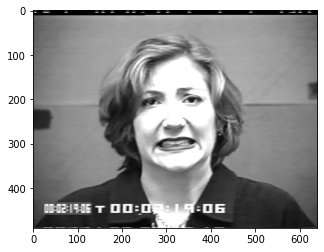

In [ ]:
plt.imshow(images[0], cmap= 'gray')

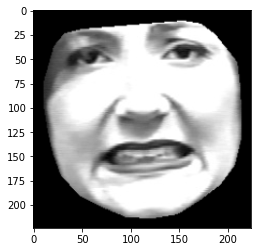

In [ ]:
plt.imshow(hasil[0], cmap = 'gray')

In [ ]:
# hasil = np.array(images)
# labels2 = labels.copy()
# hasil = hasil / 255.

In [6]:
hasil = np.array(hasil)
labels2 = np.array(labels2)
hasil = hasil / 255.

In [7]:
hasil.shape

(901, 224, 224)

In [8]:
from sklearn.model_selection import train_test_split
from tensorflow import keras
import matplotlib.pyplot as plt
from sklearn.metrics import classification_report, confusion_matrix 
from keras.utils import np_utils

from keras.models import Sequential
from keras.layers.convolutional import Convolution2D
from keras.layers.convolutional import MaxPooling2D
from keras.layers.convolutional import AveragePooling2D
from keras.layers import Dense
from keras.layers import Dropout
from keras.layers import Flatten
from keras.engine.input_layer import Input

In [9]:
x_train, x_test, y_train1, y_test1 = train_test_split(hasil, labels2, test_size= 0.2, random_state= 15, stratify=labels2)


y_train = np_utils.to_categorical(y_train1)
y_test = np_utils.to_categorical(y_test1)

In [ ]:
# x_train, x_test, y_train1, y_test1 = train_test_split(hasil, labels2, test_size= 0.3)


# y_train = np_utils.to_categorical(y_train1)
# y_test = np_utils.to_categorical(y_test1)

In [ ]:
x_train.shape

(720, 224, 224)

In [ ]:
x_test.shape

(181, 224, 224)

In [ ]:
from tensorflow.keras.models import load_model
model_CNN = load_model('Rancangan_Model_19.h5')

In [ ]:
y_pred = model_CNN.predict(x_test)
y_pred2 = np.argmax(y_pred, axis=1)
y_test2 = np.argmax(y_test, axis=1)

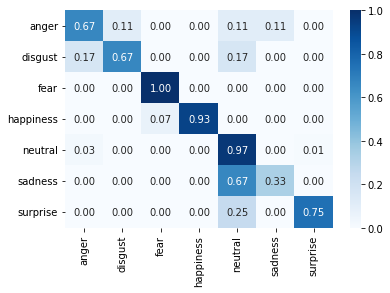

              precision    recall  f1-score   support

       anger       0.55      0.67      0.60         9
     disgust       0.89      0.67      0.76        12
        fear       0.83      1.00      0.91         5
   happiness       1.00      0.93      0.96        14
     neutral       0.91      0.97      0.94       119
     sadness       0.67      0.33      0.44         6
    surprise       0.92      0.75      0.83        16

    accuracy                           0.89       181
   macro avg       0.82      0.76      0.78       181
weighted avg       0.89      0.89      0.89       181



In [ ]:
import seaborn

CM = confusion_matrix(y_test1, y_pred2)
CM = CM.astype('float') / CM.sum(axis=1)[:, np.newaxis]
CM = seaborn.heatmap(CM, annot=True, fmt='.2f', xticklabels=class_names, yticklabels=class_names, cmap="Blues")
plt.show()
print (classification_report(y_test1, y_pred2, target_names=class_names))

In [ ]:
# Percobaan 1

# model = Sequential()
# model.add(Input(shape=(224, 224, 1)))
# model.add(Convolution2D(64, 5, 5, padding='same', activation='relu'))
# model.add(MaxPooling2D(pool_size=(5, 5), padding='same'))
# model.add(Convolution2D(64, 3, 3, padding='same', activation='relu'))
# model.add(Convolution2D(64, 3, 3, padding='same', activation='relu'))
# model.add(AveragePooling2D(pool_size=(3, 3), padding='same'))
# model.add(Convolution2D(128, 3, 3, padding='same', activation='relu'))
# model.add(Convolution2D(128, 3, 3, padding='same', activation='relu'))
# model.add(AveragePooling2D(pool_size=(3, 3), padding='same'))
# model.add(Flatten())
# model.add(Dense(1024, activation='relu'))
# model.add(Dropout(0.2))
# model.add(Dense(1024, activation='relu'))
# model.add(Dropout(0.2))
# model.add(Dense(7, activation='softmax'))
# model.compile(loss='categorical_crossentropy', optimizer='adam', metrics=['accuracy'])

In [ ]:
# Percobaan 2

# model = Sequential()
# model.add(Input(shape=(224, 224, 1)))
# model.add(Convolution2D(64, 5, 5, padding='same', activation='relu'))
# model.add(MaxPooling2D(pool_size=(5, 5), padding='same'))
# model.add(Convolution2D(64, 3, 3, padding='same', activation='relu'))
# model.add(Convolution2D(64, 3, 3, padding='same', activation='relu'))
# model.add(AveragePooling2D(pool_size=(3, 3), padding='same'))
# model.add(Convolution2D(128, 3, 3, padding='same', activation='relu'))
# model.add(Convolution2D(128, 3, 3, padding='same', activation='relu'))
# model.add(AveragePooling2D(pool_size=(3, 3), padding='same'))
# model.add(Dropout(0.2))
# model.add(Flatten())
# model.add(Dense(1024, activation='relu'))
# model.add(Dense(1024, activation='relu'))
# model.add(Dense(7, activation='softmax'))
# model.compile(loss='categorical_crossentropy', optimizer='adam', metrics=['accuracy'])

In [ ]:
# Percobaan 3

# model = Sequential()
# model.add(Input(shape=(224, 224, 1)))
# model.add(Convolution2D(64, 5, 5, padding='same', activation='relu'))
# model.add(AveragePooling2D(pool_size=(5, 5), padding='same'))
# model.add(Convolution2D(64, 3, 3, padding='same', activation='relu'))
# model.add(Convolution2D(64, 3, 3, padding='same', activation='relu'))
# model.add(AveragePooling2D(pool_size=(3, 3), padding='same'))
# model.add(Convolution2D(128, 3, 3, padding='same', activation='relu'))
# model.add(Convolution2D(128, 3, 3, padding='same', activation='relu'))
# model.add(AveragePooling2D(pool_size=(3, 3), padding='same'))
# model.add(Dropout(0.2))
# model.add(Flatten())
# model.add(Dense(1024, activation='relu'))
# model.add(Dense(1024, activation='relu'))
# model.add(Dense(7, activation='softmax'))
# model.compile(loss='categorical_crossentropy', optimizer='adam', metrics=['accuracy'])

In [ ]:
# Percobaan 4

# model = Sequential()
# model.add(Input(shape=(224, 224, 1)))
# model.add(Convolution2D(64, 5, 5, padding='same', activation='relu'))
# model.add(MaxPooling2D(pool_size=(5, 5), padding='same'))
# model.add(Convolution2D(64, 3, 3, padding='same', activation='relu'))
# model.add(Convolution2D(64, 3, 3, padding='same', activation='relu'))
# model.add(MaxPooling2D(pool_size=(3, 3), padding='same'))
# model.add(Convolution2D(128, 3, 3, padding='same', activation='relu'))
# model.add(Convolution2D(128, 3, 3, padding='same', activation='relu'))
# model.add(MaxPooling2D(pool_size=(3, 3), padding='same'))
# model.add(Dropout(0.2))
# model.add(Flatten())
# model.add(Dense(1024, activation='relu'))
# model.add(Dense(1024, activation='relu'))
# model.add(Dense(7, activation='softmax'))
# model.compile(loss='categorical_crossentropy', optimizer='adam', metrics=['accuracy'])

In [ ]:
# Percobaan 5

# model = Sequential()
# model.add(Input(shape=(224, 224, 1)))
# model.add(Convolution2D(64, 5, 5, padding='same', activation='relu'))
# model.add(MaxPooling2D(pool_size=(5, 5), padding='same'))
# model.add(Convolution2D(64, 3, 3, padding='same', activation='relu'))
# model.add(Convolution2D(64, 3, 3, padding='same', activation='relu'))
# model.add(MaxPooling2D(pool_size=(3, 3), padding='same'))
# model.add(Dropout(0.2))
# model.add(Flatten())
# model.add(Dense(1024, activation='relu'))
# model.add(Dense(1024, activation='relu'))
# model.add(Dense(7, activation='softmax'))
# model.compile(loss='categorical_crossentropy', optimizer='adam', metrics=['accuracy'])

In [ ]:
# Percobaan 6 

# model = Sequential()
# model.add(Input(shape=(224, 224, 1)))
# model.add(Convolution2D(64, 5, 5, padding='same', activation='relu'))
# model.add(AveragePooling2D(pool_size=(5, 5), padding='same'))
# model.add(Convolution2D(64, 3, 3, padding='same', activation='relu'))
# model.add(Convolution2D(64, 3, 3, padding='same', activation='relu'))
# model.add(AveragePooling2D(pool_size=(3, 3), padding='same'))
# model.add(Dropout(0.2))
# model.add(Flatten())
# model.add(Dense(1024, activation='relu'))
# model.add(Dense(1024, activation='relu'))
# model.add(Dense(7, activation='softmax'))
# model.compile(loss='categorical_crossentropy', optimizer='adam', metrics=['accuracy'])

In [ ]:
# Percobaan 7

# model = Sequential()
# model.add(Input(shape=(224, 224, 1)))
# model.add(Convolution2D(64, 5, 5, padding='same', activation='relu'))
# model.add(AveragePooling2D(pool_size=(5, 5), padding='same'))
# model.add(Convolution2D(128, 3, 3, padding='same', activation='relu'))
# model.add(Convolution2D(128, 3, 3, padding='same', activation='relu'))
# model.add(AveragePooling2D(pool_size=(3, 3), padding='same'))
# model.add(Dropout(0.2))
# model.add(Flatten())
# model.add(Dense(1024, activation='relu'))
# model.add(Dense(1024, activation='relu'))
# model.add(Dense(7, activation='softmax'))
# model.compile(loss='categorical_crossentropy', optimizer='adam', metrics=['accuracy'])

In [ ]:
# Percobaan 8

# model = Sequential()
# model.add(Input(shape=(224, 224, 1)))
# model.add(Convolution2D(64, 5, 5, padding='same', activation='relu'))
# model.add(MaxPooling2D(pool_size=(5, 5), padding='same'))
# model.add(Convolution2D(128, 3, 3, padding='same', activation='relu'))
# model.add(Convolution2D(128, 3, 3, padding='same', activation='relu'))
# model.add(MaxPooling2D(pool_size=(3, 3), padding='same'))
# model.add(Dropout(0.2))
# model.add(Flatten())
# model.add(Dense(1024, activation='relu'))
# model.add(Dense(1024, activation='relu'))
# model.add(Dense(7, activation='softmax'))
# model.compile(loss='categorical_crossentropy', optimizer='adam', metrics=['accuracy'])

In [ ]:
# Percobaan 9

# model = Sequential()
# model.add(Input(shape=(224, 224, 1)))
# model.add(Convolution2D(64, 5, 5, padding='same', activation='relu'))
# model.add(AveragePooling2D(pool_size=(5, 5), padding='same'))
# model.add(Convolution2D(64, 3, 3, padding='same', activation='relu'))
# model.add(Convolution2D(64, 3, 3, padding='same', activation='relu'))
# model.add(AveragePooling2D(pool_size=(3, 3), padding='same'))
# model.add(Dropout(0.2))
# model.add(Flatten())
# model.add(Dense(1024, activation='relu'))
# model.add(Dense(7, activation='softmax'))
# model.compile(loss='categorical_crossentropy', optimizer='adam', metrics=['accuracy'])

In [ ]:
# Percobaan 10

model = Sequential()
model.add(Input(shape=(224, 224, 1)))
model.add(Convolution2D(64, 5, 5, padding='same', activation='relu'))
model.add(AveragePooling2D(pool_size=(5, 5), padding='same'))
model.add(Convolution2D(64, 3, 3, padding='same', activation='relu'))
model.add(Convolution2D(64, 3, 3, padding='same', activation='relu'))
model.add(AveragePooling2D(pool_size=(3, 3), padding='same'))
model.add(Dropout(0.2))
model.add(Flatten())
model.add(Dense(128, activation='relu'))
model.add(Dense(7, activation='softmax'))
model.compile(loss='categorical_crossentropy', optimizer='adam', metrics=['accuracy'])

In [ ]:
from tensorflow.keras.callbacks import CSVLogger
History_Log = CSVLogger('History_Log_19_1000_Epochs.csv', separator=',', append=True)
History = model.fit(x_train, y_train, validation_split=0.2, epochs=1000, callbacks=[History_Log])

Epoch 1/1000
18/18 [==============================] - 1s 30ms/step - loss: 1.5148 - accuracy: 0.6215 - val_loss: 1.2426 - val_accuracy: 0.6528
Epoch 2/1000
18/18 [==============================] - 0s 14ms/step - loss: 1.2846 - accuracy: 0.6597 - val_loss: 1.2347 - val_accuracy: 0.6528
Epoch 3/1000
18/18 [==============================] - 0s 17ms/step - loss: 1.2755 - accuracy: 0.6597 - val_loss: 1.2315 - val_accuracy: 0.6528
Epoch 4/1000
18/18 [==============================] - 0s 13ms/step - loss: 1.2792 - accuracy: 0.6597 - val_loss: 1.2301 - val_accuracy: 0.6528
Epoch 5/1000
18/18 [==============================] - 0s 15ms/step - loss: 1.2570 - accuracy: 0.6597 - val_loss: 1.2414 - val_accuracy: 0.6528
Epoch 6/1000
18/18 [==============================] - 0s 11ms/step - loss: 1.2481 - accuracy: 0.6597 - val_loss: 1.2069 - val_accuracy: 0.6528
Epoch 7/1000
18/18 [==============================] - 0s 11ms/step - loss: 1.2222 - accuracy: 0.6597 - val_loss: 1.1957 - val_accuracy: 0.6528

In [ ]:
# History = model.fit(x_train, y_train, validation_data=(x_test, y_test), epochs=100)

In [ ]:
# from tensorflow.keras.callbacks import CSVLogger
# History_Log = CSVLogger('History_Log_20.csv', separator=',', append=True)
# History = model.fit(x_train, y_train, validation_data=(x_test, y_test), epochs=100, callbacks=[History_Log])

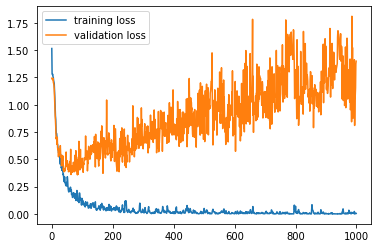

In [ ]:
plt.plot(History.history['loss'], label = 'training loss') 
plt.plot(History.history['val_loss'], label ='validation loss') 
plt.legend()

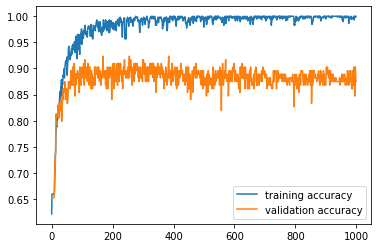

In [ ]:
plt.plot(History.history['accuracy'], label = 'training accuracy') 
plt.plot(History.history['val_accuracy'], label ='validation accuracy') 
plt.legend()

In [ ]:
y_pred = model.predict(x_test)
y_pred2 = np.argmax(y_pred, axis=1)

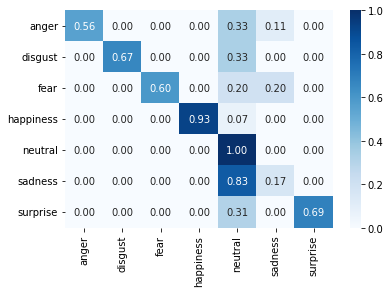

              precision    recall  f1-score   support

       anger       1.00      0.56      0.71         9
     disgust       1.00      0.67      0.80        12
        fear       1.00      0.60      0.75         5
   happiness       1.00      0.93      0.96        14
     neutral       0.86      1.00      0.93       119
     sadness       0.33      0.17      0.22         6
    surprise       1.00      0.69      0.81        16

    accuracy                           0.88       181
   macro avg       0.89      0.66      0.74       181
weighted avg       0.89      0.88      0.87       181



In [ ]:
import seaborn

CM = confusion_matrix(y_test1, y_pred2)
CM = CM.astype('float') / CM.sum(axis=1)[:, np.newaxis]
CM = seaborn.heatmap(CM, annot=True, fmt='.2f', xticklabels=class_names, yticklabels=class_names, cmap="Blues")
plt.show()
print (classification_report(y_test1, y_pred2, target_names=class_names))

In [ ]:
model.save('Rancangan_Model_19.h5')

In [ ]:
# Dropout 0.4_0.2_100

model = Sequential()
model.add(Input(shape=(224, 224, 1)))
model.add(Convolution2D(64, 5, 5, padding='same', activation='relu'))
model.add(AveragePooling2D(pool_size=(5, 5), padding='same'))
model.add(Convolution2D(64, 3, 3, padding='same', activation='relu'))
model.add(Convolution2D(64, 3, 3, padding='same', activation='relu'))
model.add(AveragePooling2D(pool_size=(3, 3), padding='same'))
model.add(Dropout(0.4))
model.add(Flatten())
model.add(Dense(128, activation='relu'))
model.add(Dropout(0.2))
model.add(Dense(7, activation='softmax'))
model.compile(loss='categorical_crossentropy', optimizer='adam', metrics=['accuracy'])

In [ ]:
from tensorflow.keras.callbacks import CSVLogger
History_Log = CSVLogger('History_Log_19_dropout_4.csv', separator=',', append=True)
History = model.fit(x_train, y_train, validation_split=0.2, epochs=100, shuffle= True, callbacks=[History_Log])

Epoch 1/100
18/18 [==============================] - 2s 74ms/step - loss: 1.6556 - accuracy: 0.5347 - val_loss: 1.2655 - val_accuracy: 0.6528
Epoch 2/100
18/18 [==============================] - 1s 62ms/step - loss: 1.3280 - accuracy: 0.6597 - val_loss: 1.2406 - val_accuracy: 0.6528
Epoch 3/100
18/18 [==============================] - 1s 63ms/step - loss: 1.2540 - accuracy: 0.6597 - val_loss: 1.2402 - val_accuracy: 0.6528
Epoch 4/100
18/18 [==============================] - 1s 63ms/step - loss: 1.2791 - accuracy: 0.6597 - val_loss: 1.2311 - val_accuracy: 0.6528
Epoch 5/100
18/18 [==============================] - 1s 63ms/step - loss: 1.2983 - accuracy: 0.6597 - val_loss: 1.2281 - val_accuracy: 0.6528
Epoch 6/100
18/18 [==============================] - 1s 64ms/step - loss: 1.2810 - accuracy: 0.6597 - val_loss: 1.2152 - val_accuracy: 0.6528
Epoch 7/100
18/18 [==============================] - 2s 91ms/step - loss: 1.2771 - accuracy: 0.6597 - val_loss: 1.2177 - val_accuracy: 0.6528
Epoch 

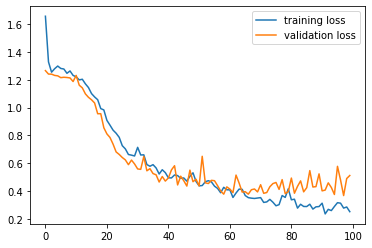

In [ ]:
plt.plot(History.history['loss'], label = 'training loss') 
plt.plot(History.history['val_loss'], label ='validation loss') 
plt.legend()

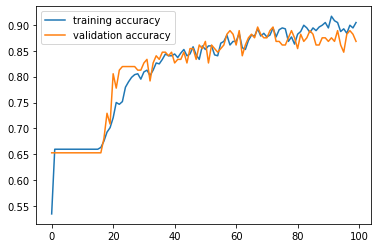

In [ ]:
plt.plot(History.history['accuracy'], label = 'training accuracy') 
plt.plot(History.history['val_accuracy'], label ='validation accuracy') 
plt.legend()

In [ ]:
y_pred = model.predict(x_test)
y_pred2 = np.argmax(y_pred, axis=1)

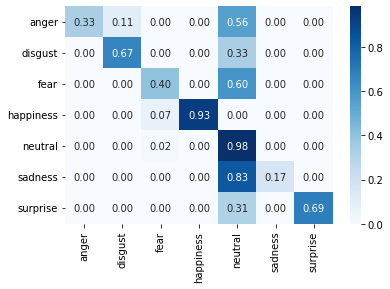

              precision    recall  f1-score   support

       anger       1.00      0.33      0.50         9
     disgust       0.89      0.67      0.76        12
        fear       0.40      0.40      0.40         5
   happiness       1.00      0.93      0.96        14
     neutral       0.84      0.98      0.91       119
     sadness       1.00      0.17      0.29         6
    surprise       1.00      0.69      0.81        16

    accuracy                           0.86       181
   macro avg       0.88      0.60      0.66       181
weighted avg       0.87      0.86      0.84       181



In [ ]:
import seaborn

CM = confusion_matrix(y_test1, y_pred2)
CM = CM.astype('float') / CM.sum(axis=1)[:, np.newaxis]
CM = seaborn.heatmap(CM, annot=True, fmt='.2f', xticklabels=class_names, yticklabels=class_names, cmap="Blues")
plt.show()
print (classification_report(y_test1, y_pred2, target_names=class_names))

In [ ]:
model.save('Rancangan_Model_19_dropout_4.h5')

In [ ]:
# Dropout 0.4_0.2_1000

model = Sequential()
model.add(Input(shape=(224, 224, 1)))
model.add(Convolution2D(64, 5, 5, padding='same', activation='relu'))
model.add(AveragePooling2D(pool_size=(5, 5), padding='same'))
model.add(Convolution2D(64, 3, 3, padding='same', activation='relu'))
model.add(Convolution2D(64, 3, 3, padding='same', activation='relu'))
model.add(AveragePooling2D(pool_size=(3, 3), padding='same'))
model.add(Dropout(0.4))
model.add(Flatten())
model.add(Dense(128, activation='relu'))
model.add(Dropout(0.2))
model.add(Dense(7, activation='softmax'))
model.compile(loss='categorical_crossentropy', optimizer='adam', metrics=['accuracy'])

In [ ]:
from tensorflow.keras.callbacks import CSVLogger
History_Log = CSVLogger('History_Log_19_dropout_4_1000_Epoch.csv', separator=',', append=True)
History = model.fit(x_train, y_train, validation_split=0.2, epochs=1000, shuffle= True, callbacks=[History_Log])

Epoch 1/1000
18/18 [==============================] - 2s 72ms/step - loss: 1.5961 - accuracy: 0.6111 - val_loss: 1.3061 - val_accuracy: 0.6528
Epoch 2/1000
18/18 [==============================] - 1s 63ms/step - loss: 1.3226 - accuracy: 0.6597 - val_loss: 1.2395 - val_accuracy: 0.6528
Epoch 3/1000
18/18 [==============================] - 1s 62ms/step - loss: 1.3058 - accuracy: 0.6597 - val_loss: 1.2426 - val_accuracy: 0.6528
Epoch 4/1000
18/18 [==============================] - 1s 64ms/step - loss: 1.2963 - accuracy: 0.6597 - val_loss: 1.2340 - val_accuracy: 0.6528
Epoch 5/1000
18/18 [==============================] - 1s 63ms/step - loss: 1.2701 - accuracy: 0.6597 - val_loss: 1.2280 - val_accuracy: 0.6528
Epoch 6/1000
18/18 [==============================] - 1s 63ms/step - loss: 1.2724 - accuracy: 0.6597 - val_loss: 1.2288 - val_accuracy: 0.6528
Epoch 7/1000
18/18 [==============================] - 1s 62ms/step - loss: 1.2604 - accuracy: 0.6597 - val_loss: 1.2514 - val_accuracy: 0.6528

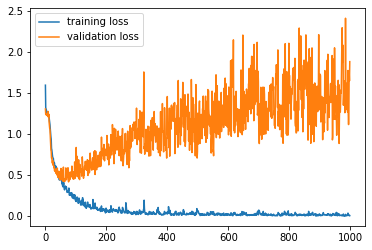

In [ ]:
plt.plot(History.history['loss'], label = 'training loss') 
plt.plot(History.history['val_loss'], label ='validation loss') 
plt.legend()

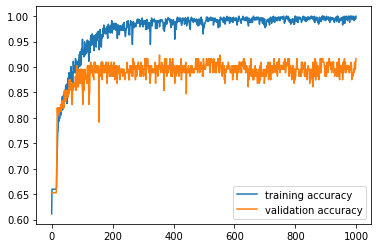

In [ ]:
plt.plot(History.history['accuracy'], label = 'training accuracy') 
plt.plot(History.history['val_accuracy'], label ='validation accuracy') 
plt.legend()

In [ ]:
y_pred = model.predict(x_test)
y_pred2 = np.argmax(y_pred, axis=1)

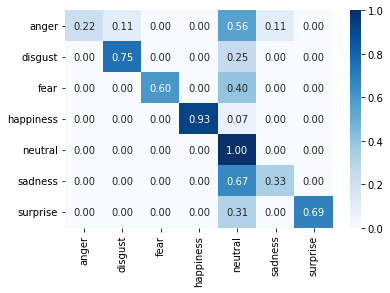

              precision    recall  f1-score   support

       anger       1.00      0.22      0.36         9
     disgust       0.90      0.75      0.82        12
        fear       1.00      0.60      0.75         5
   happiness       1.00      0.93      0.96        14
     neutral       0.86      1.00      0.92       119
     sadness       0.67      0.33      0.44         6
    surprise       1.00      0.69      0.81        16

    accuracy                           0.88       181
   macro avg       0.92      0.65      0.73       181
weighted avg       0.89      0.88      0.86       181



In [ ]:
import seaborn

CM = confusion_matrix(y_test1, y_pred2)
CM = CM.astype('float') / CM.sum(axis=1)[:, np.newaxis]
CM = seaborn.heatmap(CM, annot=True, fmt='.2f', xticklabels=class_names, yticklabels=class_names, cmap="Blues")
plt.show()
print (classification_report(y_test1, y_pred2, target_names=class_names))

In [ ]:
model.save('Rancangan_Model_19_dropout_4_1000_Epoch.h5')

In [10]:
# Dropout 0.4_2_100

model = Sequential()
model.add(Input(shape=(224, 224, 1)))
model.add(Convolution2D(64, 5, 5, padding='same', activation='relu'))
model.add(AveragePooling2D(pool_size=(5, 5), padding='same'))
model.add(Convolution2D(64, 3, 3, padding='same', activation='relu'))
model.add(Convolution2D(64, 3, 3, padding='same', activation='relu'))
model.add(AveragePooling2D(pool_size=(3, 3), padding='same'))
model.add(Dropout(0.4))
model.add(Flatten())
model.add(Dense(128, activation='relu'))
model.add(Dropout(0.4))
model.add(Dense(7, activation='softmax'))
model.compile(loss='categorical_crossentropy', optimizer='adam', metrics=['accuracy'])

In [11]:
from tensorflow.keras.callbacks import CSVLogger
History_Log = CSVLogger('History_Log_19_dropout_4_2_100_Epoch.csv', separator=',', append=True)
History = model.fit(x_train, y_train, validation_split=0.2, epochs=100, shuffle= True, callbacks=[History_Log])

Epoch 1/100
18/18 [==============================] - 12s 28ms/step - loss: 1.5323 - accuracy: 0.6337 - val_loss: 1.2856 - val_accuracy: 0.6528
Epoch 2/100
18/18 [==============================] - 0s 11ms/step - loss: 1.3328 - accuracy: 0.6597 - val_loss: 1.2471 - val_accuracy: 0.6528
Epoch 3/100
18/18 [==============================] - 0s 11ms/step - loss: 1.2995 - accuracy: 0.6597 - val_loss: 1.2250 - val_accuracy: 0.6528
Epoch 4/100
18/18 [==============================] - 0s 11ms/step - loss: 1.2825 - accuracy: 0.6597 - val_loss: 1.2568 - val_accuracy: 0.6528
Epoch 5/100
18/18 [==============================] - 0s 12ms/step - loss: 1.2888 - accuracy: 0.6597 - val_loss: 1.2731 - val_accuracy: 0.6528
Epoch 6/100
18/18 [==============================] - 0s 12ms/step - loss: 1.2834 - accuracy: 0.6597 - val_loss: 1.2692 - val_accuracy: 0.6528
Epoch 7/100
18/18 [==============================] - 0s 10ms/step - loss: 1.2858 - accuracy: 0.6597 - val_loss: 1.2238 - val_accuracy: 0.6528
Epoch

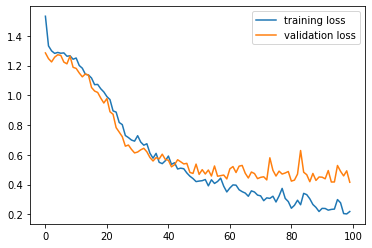

In [12]:
plt.plot(History.history['loss'], label = 'training loss') 
plt.plot(History.history['val_loss'], label ='validation loss') 
plt.legend()

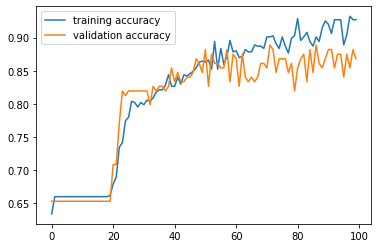

In [13]:
plt.plot(History.history['accuracy'], label = 'training accuracy') 
plt.plot(History.history['val_accuracy'], label ='validation accuracy') 
plt.legend()

In [14]:
y_pred = model.predict(x_test)
y_pred2 = np.argmax(y_pred, axis=1)

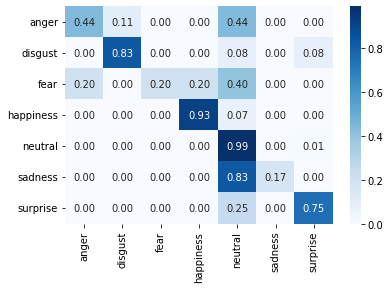

              precision    recall  f1-score   support

       anger       0.80      0.44      0.57         9
     disgust       0.91      0.83      0.87        12
        fear       1.00      0.20      0.33         5
   happiness       0.93      0.93      0.93        14
     neutral       0.87      0.99      0.93       119
     sadness       1.00      0.17      0.29         6
    surprise       0.86      0.75      0.80        16

    accuracy                           0.88       181
   macro avg       0.91      0.62      0.67       181
weighted avg       0.88      0.88      0.86       181



In [15]:
import seaborn

CM = confusion_matrix(y_test1, y_pred2)
CM = CM.astype('float') / CM.sum(axis=1)[:, np.newaxis]
CM = seaborn.heatmap(CM, annot=True, fmt='.2f', xticklabels=class_names, yticklabels=class_names, cmap="Blues")
plt.show()
print (classification_report(y_test1, y_pred2, target_names=class_names))

In [16]:
model.save('Rancangan_Model_19_dropout_4_2_100_Epoch.h5')

In [17]:
# Dropout 0.4_2_1000

model = Sequential()
model.add(Input(shape=(224, 224, 1)))
model.add(Convolution2D(64, 5, 5, padding='same', activation='relu'))
model.add(AveragePooling2D(pool_size=(5, 5), padding='same'))
model.add(Convolution2D(64, 3, 3, padding='same', activation='relu'))
model.add(Convolution2D(64, 3, 3, padding='same', activation='relu'))
model.add(AveragePooling2D(pool_size=(3, 3), padding='same'))
model.add(Dropout(0.4))
model.add(Flatten())
model.add(Dense(128, activation='relu'))
model.add(Dropout(0.4))
model.add(Dense(7, activation='softmax'))
model.compile(loss='categorical_crossentropy', optimizer='adam', metrics=['accuracy'])

In [18]:
from tensorflow.keras.callbacks import CSVLogger
History_Log = CSVLogger('History_Log_19_dropout_4_2_1000_Epoch.csv', separator=',', append=True)
History = model.fit(x_train, y_train, validation_split=0.2, epochs=1000, shuffle= True, callbacks=[History_Log])

Epoch 1/1000
18/18 [==============================] - 1s 22ms/step - loss: 1.7365 - accuracy: 0.5208 - val_loss: 1.3099 - val_accuracy: 0.6528
Epoch 2/1000
18/18 [==============================] - 0s 13ms/step - loss: 1.3342 - accuracy: 0.6562 - val_loss: 1.2457 - val_accuracy: 0.6528
Epoch 3/1000
18/18 [==============================] - 0s 12ms/step - loss: 1.3482 - accuracy: 0.6597 - val_loss: 1.2422 - val_accuracy: 0.6528
Epoch 4/1000
18/18 [==============================] - 0s 11ms/step - loss: 1.3304 - accuracy: 0.6597 - val_loss: 1.2429 - val_accuracy: 0.6528
Epoch 5/1000
18/18 [==============================] - 0s 11ms/step - loss: 1.2846 - accuracy: 0.6580 - val_loss: 1.2305 - val_accuracy: 0.6528
Epoch 6/1000
18/18 [==============================] - 0s 11ms/step - loss: 1.3017 - accuracy: 0.6597 - val_loss: 1.2375 - val_accuracy: 0.6528
Epoch 7/1000
18/18 [==============================] - 0s 11ms/step - loss: 1.2743 - accuracy: 0.6597 - val_loss: 1.2240 - val_accuracy: 0.6528

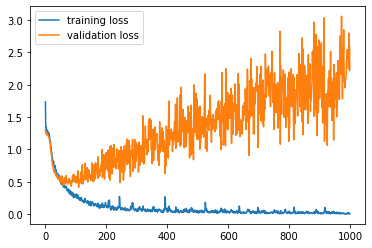

In [19]:
plt.plot(History.history['loss'], label = 'training loss') 
plt.plot(History.history['val_loss'], label ='validation loss') 
plt.legend()

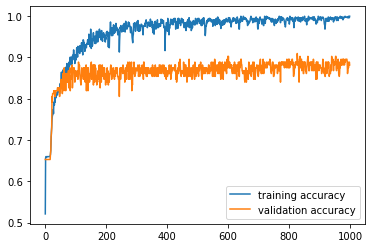

In [20]:
plt.plot(History.history['accuracy'], label = 'training accuracy') 
plt.plot(History.history['val_accuracy'], label ='validation accuracy') 
plt.legend()

In [21]:
y_pred = model.predict(x_test)
y_pred2 = np.argmax(y_pred, axis=1)

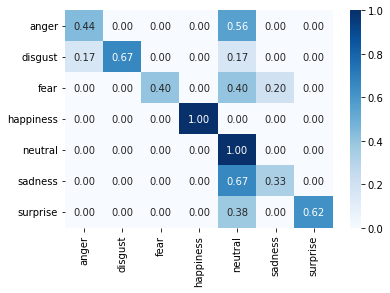

              precision    recall  f1-score   support

       anger       0.67      0.44      0.53         9
     disgust       1.00      0.67      0.80        12
        fear       1.00      0.40      0.57         5
   happiness       1.00      1.00      1.00        14
     neutral       0.86      1.00      0.93       119
     sadness       0.67      0.33      0.44         6
    surprise       1.00      0.62      0.77        16

    accuracy                           0.88       181
   macro avg       0.89      0.64      0.72       181
weighted avg       0.88      0.88      0.86       181



In [22]:
import seaborn

CM = confusion_matrix(y_test1, y_pred2)
CM = CM.astype('float') / CM.sum(axis=1)[:, np.newaxis]
CM = seaborn.heatmap(CM, annot=True, fmt='.2f', xticklabels=class_names, yticklabels=class_names, cmap="Blues")
plt.show()
print (classification_report(y_test1, y_pred2, target_names=class_names))

In [23]:
model.save('Rancangan_Model_19_dropout_4_2_1000_Epoch.h5')